In [1]:
import numpy as np


def load_camel():
    x = np.load('../datas/camel.npy')
    x = x.astype(np.float32)
    x = (x - 127.5) / 127.5
    x = x.reshape(x.shape[0], 28, 28, 1)
    x = x[:8000]

    return x


x = load_camel()

x.shape

(8000, 28, 28, 1)

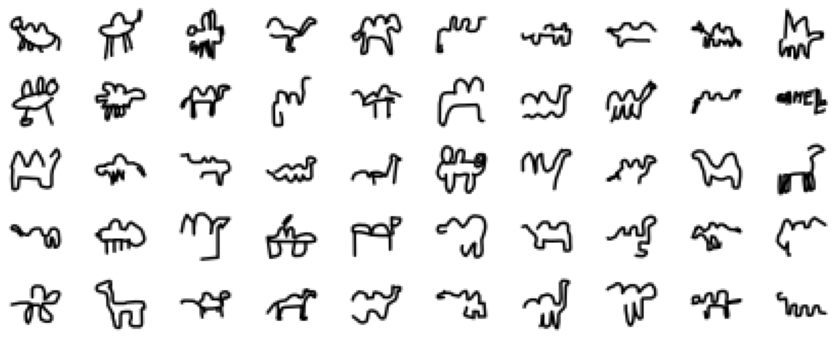

In [2]:
from matplotlib import pyplot as plt
%matplotlib inline


def show(images):
    plt.figure(figsize=(15, 6))

    for i in range(len(images)):
        plt.subplot(5, 10, i + 1)
        plt.imshow(images[i].squeeze(), cmap='gray_r')
        plt.axis('off')

    plt.show()


show(x[:50])

In [3]:
import keras

weight_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

cls = keras.models.Sequential([
    keras.layers.Conv2D(filters=64,
                        kernel_size=5,
                        strides=2,
                        padding='same',
                        kernel_initializer=weight_init,
                        input_shape=(28, 28, 1)),
    keras.layers.Activation('relu'),
    keras.layers.Dropout(rate=0.4),
    keras.layers.Conv2D(filters=64,
                        kernel_size=5,
                        strides=2,
                        padding='same',
                        kernel_initializer=weight_init),
    keras.layers.Activation('relu'),
    keras.layers.Dropout(rate=0.4),
    keras.layers.Conv2D(filters=128,
                        kernel_size=5,
                        strides=2,
                        padding='same',
                        kernel_initializer=weight_init),
    keras.layers.Activation('relu'),
    keras.layers.Dropout(rate=0.4),
    keras.layers.Conv2D(filters=128,
                        kernel_size=5,
                        strides=1,
                        padding='same',
                        kernel_initializer=weight_init),
    keras.layers.Activation('relu'),
    keras.layers.Dropout(rate=0.4),
    keras.layers.Flatten(),
    keras.layers.Dense(1, activation='sigmoid',
                       kernel_initializer=weight_init),
])

gen = keras.models.Sequential([
    keras.layers.Dense((7 * 7 * 64),
                       kernel_initializer=weight_init,
                       input_shape=(100, )),
    keras.layers.BatchNormalization(momentum=0.9),
    keras.layers.Activation('relu'),
    keras.layers.Reshape((7, 7, 64)),
    keras.layers.UpSampling2D(),
    keras.layers.Conv2D(filters=128,
                        kernel_size=5,
                        padding='same',
                        kernel_initializer=weight_init),
    keras.layers.BatchNormalization(momentum=0.9),
    keras.layers.Activation('relu'),
    keras.layers.UpSampling2D(),
    keras.layers.Conv2D(filters=64,
                        kernel_size=5,
                        padding='same',
                        kernel_initializer=weight_init),
    keras.layers.BatchNormalization(momentum=0.9),
    keras.layers.Activation('relu'),
    keras.layers.Conv2DTranspose(filters=64,
                                 kernel_size=5,
                                 padding='same',
                                 strides=1,
                                 kernel_initializer=weight_init),
    keras.layers.BatchNormalization(momentum=0.9),
    keras.layers.Activation('relu'),
    keras.layers.Conv2DTranspose(filters=1,
                                 kernel_size=5,
                                 padding='same',
                                 strides=1,
                                 kernel_initializer=weight_init),
    keras.layers.Activation('tanh'),
])

cls, gen

Using TensorFlow backend.






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.





(<keras.engine.sequential.Sequential at 0x7f1d5363ef98>,
 <keras.engine.sequential.Sequential at 0x7f1d52c34f28>)

In [4]:
cls.compile(optimizer=keras.optimizers.RMSprop(lr=8e-4),
            loss='binary_crossentropy',
            metrics=['accuracy'])

cls.trainable = False
for i in cls.layers:
    i.trainable = False

gan = keras.models.Sequential([gen, cls])
gan.compile(optimizer=keras.optimizers.RMSprop(lr=4e-4),
            loss='binary_crossentropy',
            metrics=['accuracy'])

cls.trainable = True
for i in cls.layers:
    i.trainable = True

gan


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


/root/anaconda3/envs/gdl/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0 0.203125 0.0


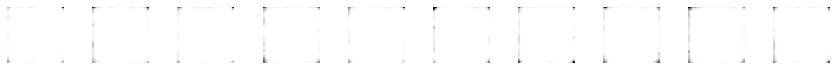

/root/anaconda3/envs/gdl/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


20 0.4296875 0.21875


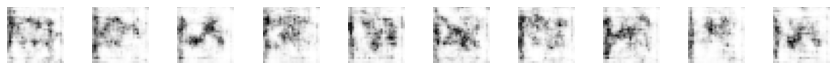

40 0.1953125 0.0


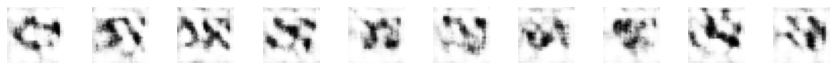

60 0.4140625 0.046875


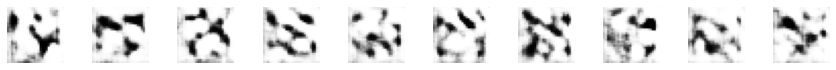

80 0.5 0.0


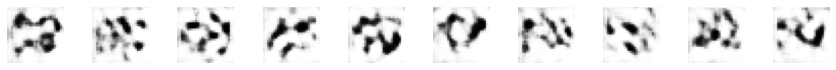

100 0.3359375 0.015625


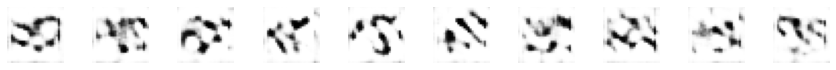

120 0.5 0.375


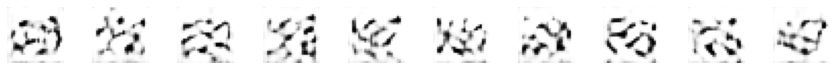

140 0.4765625 0.421875


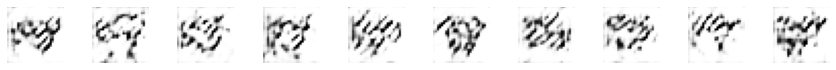

160 0.546875 0.71875


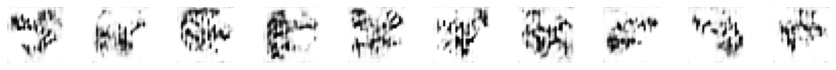

180 0.5234375 0.6875


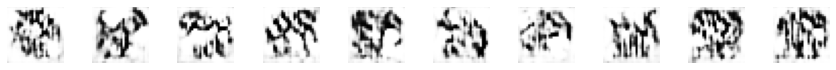

200 0.6015625 0.6875


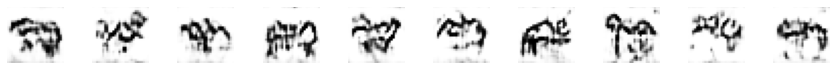

220 0.5546875 0.578125


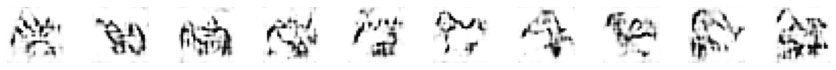

240 0.5 0.4375


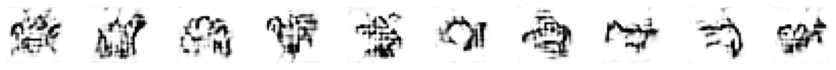

260 0.6171875 0.671875


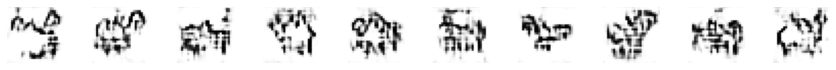

280 0.453125 0.515625


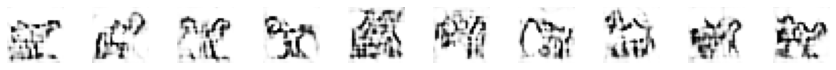

300 0.4921875 0.5


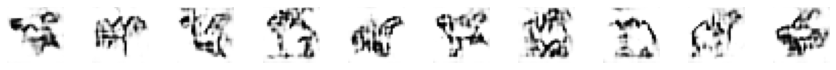

320 0.5390625 0.625


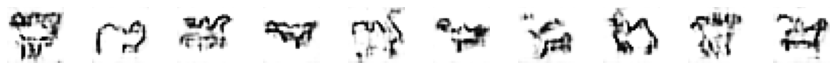

340 0.6015625 0.5


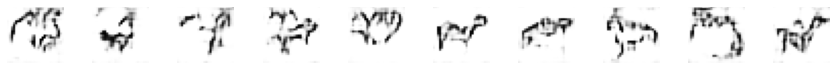

360 0.5703125 0.546875


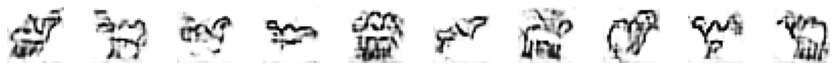

380 0.5625 0.46875


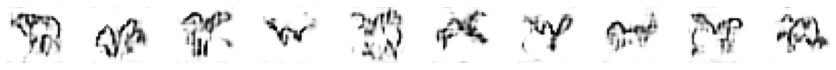

400 0.5078125 0.5625


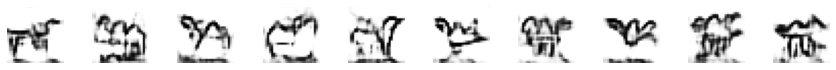

420 0.5859375 0.578125


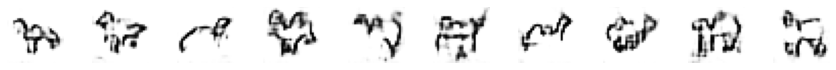

440 0.609375 0.53125


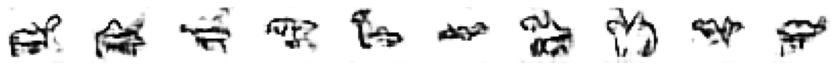

460 0.53125 0.546875


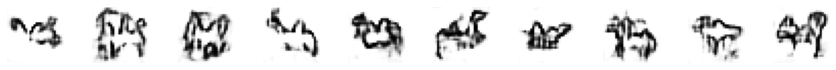

480 0.546875 0.453125


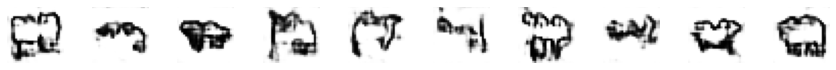

In [5]:
def train():

    def train_cls():
        input_gen = np.random.normal(0, 1, (64, 100))
        output_gen = gen.predict(input_gen)
        _, acc_gen = cls.train_on_batch(output_gen, np.zeros((64, 1)))

        select = np.random.randint(0, x.shape[0], 64)
        _, acc_true = cls.train_on_batch(x[select], np.ones((64, 1)))

        return (acc_gen + acc_true) / 2

    def train_gen():
        input_gan = np.random.normal(0, 1, (64, 100))

        _, acc = gan.train_on_batch(input_gan, np.ones((64, 1)))

        return acc

    for epoch in range(500):
        acc_cls = train_cls()
        acc_gen = train_gen()

        if epoch % 20 == 0:
            print(epoch, acc_cls, acc_gen)
            pred = gen.predict(np.random.normal(0, 1, (10, 100)))
            show(pred)


train()

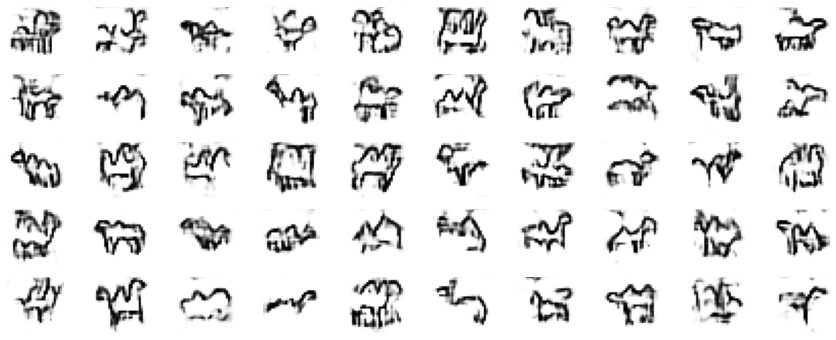

In [6]:
#生成
pred = gen.predict(np.random.randn(50, 100))

show(pred)